In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from transformers import CLIPProcessor, CLIPModel
import clip
from PIL import Image
import matplotlib.pyplot as plt
import csv
import pandas as pd

In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, csv_path, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transforms.ToTensor() if transform is None else transform
        self.class_labels = pd.read_csv(csv_path)
        
        self.images = []
        for img in os.listdir(image_dir):
            if img.lower().endswith(('.jpg', '.jpeg', '.png')):
                self.images.append(os.path.join(image_dir, img))
        self.images.sort()
        
        self.masks = sorted([mask for mask in os.listdir(mask_dir) if mask.lower().endswith('.png')])
        
        self.matched_pairs = []
        mask_basenames = {os.path.splitext(os.path.basename(mask))[0]: mask for mask in self.masks}
        
        for img_path in self.images:
            img_basename = os.path.splitext(os.path.basename(img_path))[0]
            if img_basename in mask_basenames:
                self.matched_pairs.append((img_path, mask_basenames[img_basename]))
        
        if len(self.matched_pairs) == 0:
            raise ValueError(f"No matching image-mask pairs found. Check that filenames match between directories.")
        
        print(f"Found {len(self.matched_pairs)} matched image-mask pairs in {image_dir} and {mask_dir}")
        
        try:
            self.clip_model, self.preprocess = clip.load("ViT-B/32", device=device)
            self.clip_model.eval()
        except Exception as e:
            print(f"Error loading CLIP model: {e}")
            raise
    
    def __len__(self):
        return len(self.matched_pairs)
    
    def __getitem__(self, idx):
        img_path, mask_path = self.matched_pairs[idx]
        mask_path = os.path.join(self.mask_dir, mask_path)
        img_filename = os.path.basename(img_path)
        
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        
        # Get class label from CSV
        labels = self.class_labels.loc[self.class_labels['filename'] == img_filename, 'label'].values
        class_label = labels[0] if len(labels) > 0 else 0
        
        mask = np.array(mask, dtype=np.uint8)
        mask[mask != 0] = class_label
        mask = torch.tensor(mask, dtype=torch.long)
        
        # Process image for CLIP
        clip_input = self.transform(image).float()
        
        # Get original image dimensions for resizing later
        original_size = image.size
        
        return clip_input, mask, original_size, img_filename

In [6]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import clip
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score

class CLIPSegmentationModel(nn.Module):
    def __init__(self, clip_model, num_classes=3):
        super().__init__()
        self.clip_model = clip_model
        
        self.clip_dtype = self.clip_model.visual.conv1.weight.dtype

        # Freeze CLIP parameters
        for param in self.clip_model.parameters():
            param.requires_grad = False
        
        # Extract feature dimensions from CLIP
        self.feature_dim = self.clip_model.visual.output_dim  # 512 for ViT-B/32

        # Decoder network
        self.decoder = nn.Sequential(
            nn.Conv2d(self.feature_dim, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, num_classes, kernel_size=1)
        )
        
        # Text embeddings for classes
        self.register_text_embeddings()
    
    def register_text_embeddings(self):
        # Create text embeddings for our classes
        text_inputs = torch.cat([
            clip.tokenize("a background"),
            clip.tokenize("a cat"),
            clip.tokenize("a dog")
        ]).to(device)
        
        with torch.no_grad():
            self.text_features = self.clip_model.encode_text(text_inputs)
            self.text_features = F.normalize(self.text_features, dim=1)
        
        # Save text features as a buffer
        self.register_buffer("class_embeddings", self.text_features)


    def extract_features(self, x):
        # Get CLIP features
        x = x.float()

        with torch.no_grad():
            features = self.clip_model.encode_image(x)
            
        # Normalize features
        features = F.normalize(features, dim=1)
        
        # Reshape to spatial dimensions
        batch_size = features.shape[0]
        h = w = int(x.shape[2] / 32)  # CLIP ViT-B/32 downsamples by 32
        features = features.reshape(batch_size, self.feature_dim, 1, 1)
        features = F.interpolate(features, size=(h, w), mode='bilinear', align_corners=False)
        
        return features.float()

    def forward(self, x):
        # Extract features from CLIP
        x = x.to(self.clip_dtype)

        features = self.extract_features(x)
        # Decode features to segmentation map
        logits = self.decoder(features)
        
        logits = logits.float()
        # Upsample to original image size
        logits = F.interpolate(logits, size=(x.shape[2], x.shape[3]), mode='bilinear', align_corners=False)
        
        return logits

In [7]:
def train_model(model, train_loader, val_loader, num_epochs=15, lr=1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)
    
    best_val_loss = float('inf')
    history = {'train_loss': [], 'val_loss': [], 'val_iou': []}
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        #pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for images, masks, _, _ in train_loader:
            images = images.float().to(device)
            masks = masks.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            #pbar.set_postfix({'loss': loss.item()})
        
        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)
        
        # Validation
        val_loss, val_iou = evaluate_model(model, val_loader, criterion)
        history['val_loss'].append(val_loss)
        history['val_iou'].append(val_iou)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}')
        
        # Learning rate scheduler
        scheduler.step(val_loss)
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_clip_segmentation_model.pth')
            print("Saved best model checkpoint")
    
    # Plot training history
    #plot_training_history(history)
    
    return model, history

In [8]:
def evaluate_model(model, dataloader, criterion=None):
    model.eval()
    val_loss = 0.0
    class_stats = {i: {"intersection": 0, "union": 0} for i in range(3)}
    
    with torch.no_grad():
        for images, masks, _, _ in dataloader:
            images = images.float().to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            
            if criterion:
                loss = criterion(outputs, masks)
                val_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1)
            masks_cpu = masks.cpu().numpy()
            preds_cpu = preds.cpu().numpy()
            
            # Calculate IoU statistics for each class batch by batch
            for class_idx in range(3):
                # Create binary masks for this class
                class_mask = (masks_cpu == class_idx)
                class_pred = (preds_cpu == class_idx)
                
                # Calculate intersection and union
                intersection = np.logical_and(class_mask, class_pred).sum()
                union = np.logical_or(class_mask, class_pred).sum()
                
                # Update counters
                class_stats[class_idx]["intersection"] += intersection
                class_stats[class_idx]["union"] += union
    
    # Calculate IoU score for each class and mean IoU
    iou_scores = []
    for class_idx in range(3):
        intersection = class_stats[class_idx]["intersection"]
        union = class_stats[class_idx]["union"]
        # Avoid division by zero
        iou = intersection / union if union > 0 else 0.0
        iou_scores.append(iou)
    
    mean_iou = np.mean(iou_scores)
    
    if criterion:
        val_loss /= len(dataloader)
        return val_loss, mean_iou
    else:
        return mean_iou


In [ ]:
image_dir = "C:/Users/louis/Documents/CV/processed_dataset/color/"
mask_dir = "C:/Users/louis/Documents/CV/processed_dataset/label/"
csv_path = "C:/Users/louis/Documents/CV/processed_dataset/labels.csv"
# Create datasets and dataloaders

# Create train/val/test splits (assuming 70/15/15 split)
dataset = SegmentationDataset(image_dir, mask_dir, csv_path)
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
val_size = dataset_size - train_size

train_dataset, val_dataset, = torch.utils.data.random_split(
    dataset, [train_size, val_size]
)


batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Create and train 
clip_model, _ = clip.load("ViT-B/32", device=device)
model = CLIPSegmentationModel(clip_model).to(device)
model, history = train_model(model, train_loader, val_loader, num_epochs=15)

# Evaluate on test set

# Visualize some results
#visualize_predictions(model, test_loader)

Found 3680 matched image-mask pairs in C:/Users/louis/Documents/CV/processed_dataset/color/ and C:/Users/louis/Documents/CV/processed_dataset/label/
Found 3710 matched image-mask pairs in C:/Users/louis/Documents/CV/processed_dataset_test/color/ and C:/Users/louis/Documents/CV/processed_dataset_test/label/
Epoch 1/15, Train Loss: 0.4965, Val Loss: 0.3778, Val IoU: 0.6649
Saved best model checkpoint
Epoch 2/15, Train Loss: 0.3835, Val Loss: 0.3482, Val IoU: 0.6746
Saved best model checkpoint
Epoch 3/15, Train Loss: 0.3526, Val Loss: 0.3315, Val IoU: 0.6716
Saved best model checkpoint
Epoch 4/15, Train Loss: 0.3380, Val Loss: 0.3253, Val IoU: 0.6751
Saved best model checkpoint
Epoch 5/15, Train Loss: 0.3270, Val Loss: 0.3234, Val IoU: 0.6825
Saved best model checkpoint
Epoch 6/15, Train Loss: 0.3182, Val Loss: 0.3188, Val IoU: 0.6756
Saved best model checkpoint
Epoch 7/15, Train Loss: 0.3085, Val Loss: 0.3264, Val IoU: 0.6727
Epoch 8/15, Train Loss: 0.3009, Val Loss: 0.3233, Val IoU: 0.6

In [9]:
image_test_dir = "C:/Users/louis/Documents/CV/processed_dataset_test/color/"
mask_test_dir = "C:/Users/louis/Documents/CV/processed_dataset_test/label/"
csv_test_path = "C:/Users/louis/Documents/CV/processed_dataset_test/labels.csv"


clip_model, _ = clip.load("ViT-B/32", device=device)
model = CLIPSegmentationModel(clip_model).to(device)
model.load_state_dict(torch.load("best_clip_segmentation_model.pth", map_location=device))

batch_size = 8
test_dataset = SegmentationDataset(image_test_dir, mask_test_dir, csv_test_path)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

test_iou = evaluate_model(model, test_loader)
print(f"Test IoU: {test_iou:.4f}")


Found 3710 matched image-mask pairs in C:/Users/louis/Documents/CV/processed_dataset_test/color/ and C:/Users/louis/Documents/CV/processed_dataset_test/label/
Test IoU: 0.6751


In [10]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['val_iou'], label='Validation IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.close()

In [11]:
def predict_image(model, image_path):
    model.eval()
    
    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    transform = transforms.ToTensor()
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    # Make prediction
    with torch.no_grad():
        output = model(input_tensor)
        pred = torch.argmax(output, dim=1)[0].cpu().numpy()
    
    # Visualize result
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')
    
    class_colors = {0: [0, 0, 0], 1: [1, 0, 0], 2: [0, 0, 1]}  # Background: black, Cat: red, Dog: blue
    pred_colored = np.zeros((pred.shape[0], pred.shape[1], 3))
    for cls in range(3):
        pred_colored[pred == cls] = class_colors[cls]
    
    plt.subplot(1, 2, 2)
    plt.imshow(pred_colored)
    plt.title('Segmentation Result')
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('prediction_result.png')
    plt.show()
    
    return pred

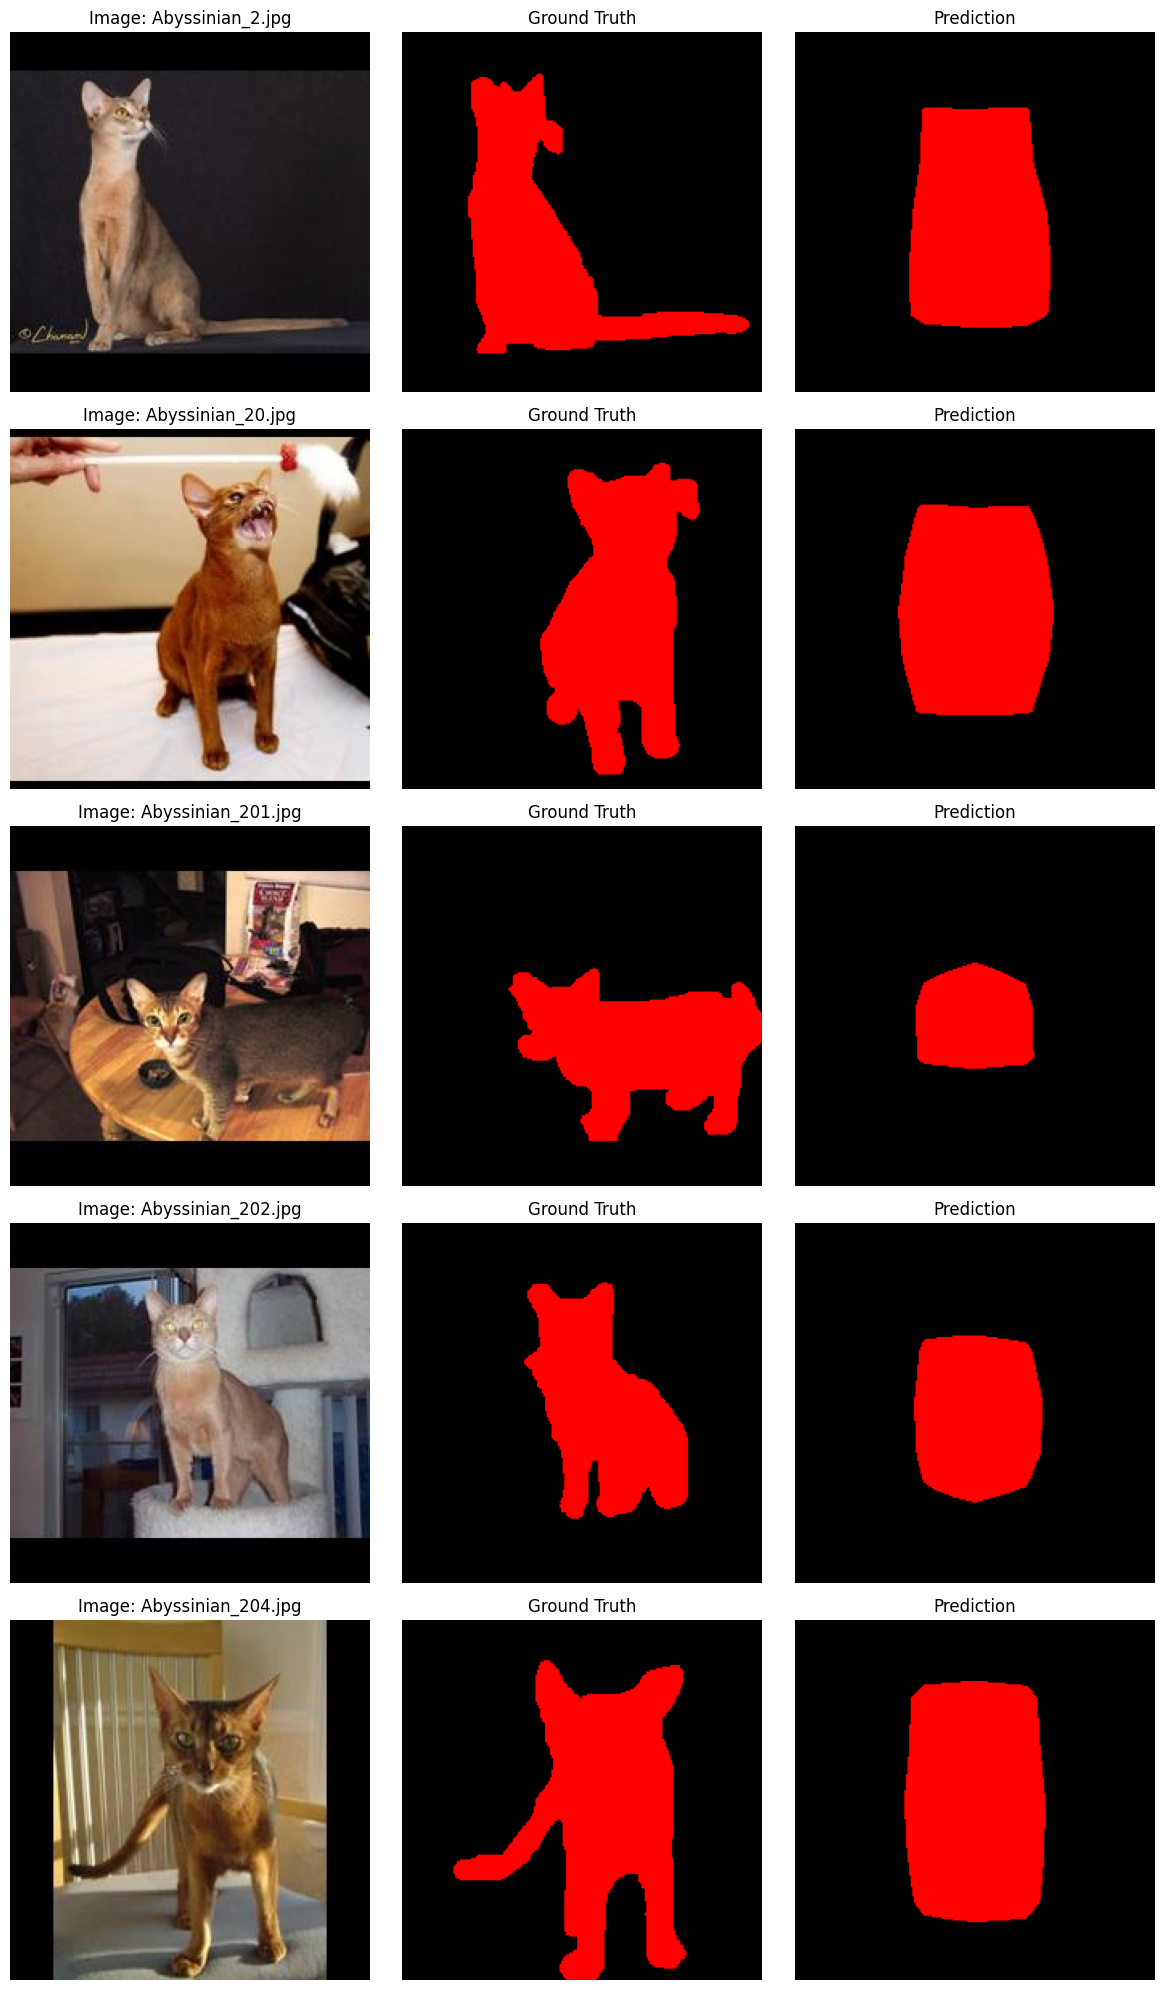

In [12]:
num_samples=5
model.eval()

samples = []
with torch.no_grad():
    for images, masks, _, filenames in test_loader:
        if len(samples) >= num_samples:
            break
            
        images = images.to(device)
        masks = masks.cpu().numpy()
        
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        
        for i in range(images.shape[0]):
            if len(samples) < num_samples:
                samples.append((images[i].cpu(), masks[i], preds[i], filenames[i]))

fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
class_colors = {0: [0, 0, 0], 1: [1, 0, 0], 2: [0, 0, 1]}  # Background: black, Cat: red, Dog: blue

for i, (image, mask, pred, filename) in enumerate(samples):
    # Convert image from tensor [C,H,W] to numpy [H,W,C]
    img_np = image.permute(1, 2, 0).numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
    
    # Create colored mask and prediction
    mask_colored = np.zeros((mask.shape[0], mask.shape[1], 3))
    pred_colored = np.zeros((pred.shape[0], pred.shape[1], 3))
    
    for cls in range(3):
        mask_colored[mask == cls] = class_colors[cls]
        pred_colored[pred == cls] = class_colors[cls]
    
    # Plot
    axes[i, 0].imshow(img_np)
    axes[i, 0].set_title(f"Image: {filename}")
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(mask_colored)
    axes[i, 1].set_title("Ground Truth")
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(pred_colored)
    axes[i, 2].set_title("Prediction")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.savefig('segmentation_results.png')
plt.show()
plt.close()
